<h1 style="font-size:2.5rem; color:green;"> Taylor diagram for pattern correlation of monthly values of spatial means of snow cover from different products </h1>  

<a href="https://github.com/mickaellalande/CMIP6_HMA_paper/blob/main/fig_taylor_diagram-PCC.ipynb"> Taylor diagram github Mickael Lalande</a>

<h1 style="font-size:2rem; color:green;"> Initialization of global variables </h1>

In [1]:
# To reload external files automatically (ex: utils)
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy
from matplotlib.projections import PolarAxes
import mpl_toolkits.axisartist.grid_finder as gf
import mpl_toolkits.axisartist.floating_axes as fa

<h1 style="font-size:2rem; color:green;"> Set variables </h1>

In [2]:
"""
We define the threshold used to deduce number of days with snow over land from snow cover fraction
threshold = '0' <=> 0%, threshold = '1' <=> 1%, threshold = '3' <=> 3% 
"""
threshold = '0' 

# Set elevation ranges list
bounds = ['1000m_1500m', '1500m_2000m', '2000m_5000m'] 

# Product used as reference
ref = 'ESA_GF'        

# Set input data path
path_input = '/home/hamid/Data/snow/scfg/spatial_averages_by_alt_bounds_monthly_values/threshold_'+threshold+'/where_alt_between_'

# Set path of directories in which results will be stored
output_path_taylor = '/home/hamid/PHD-mountain-climate/First_Part/Results/figures/comparison/period_comparison/taylor_diagram/spatial_means/altitude_bounds/v1/threshold_'+threshold

products_labels = ['ESA_ORIG','ESA_GF','ERA_LAND','ERA5','SIM_35km','SIM_50km']
ref_order = products_labels.index(ref)

products_labels_to_assess = ['ESA_ORIG', 'ESA_GF', 'ERA_LAND', 'ERA5', 'SIM_35km', 'SIM_50km']
products_labels_to_assess.remove(ref)
                               
dic_data = {bound:{key:'data' for key in products_labels} for bound in bounds}   

months_labels = {11:'November', 12:'December', 1:'January',2:'February',3:'Mars',4:'April'}
period = slice('1982-01-01', '2014-12-31')
parameters = ['scf_monthly_value_15', 'ext_days_with_snow_15']

<h1 style="font-size:2rem; color:green;"> Importing and preprocessing data </h1>

In [3]:
for bound in bounds:
    for prod in products_labels:
        dic_data[bound][prod] = xr.open_dataset(path_input+bound+'/'+prod+'_spatial_mean_where_alt_between_'+bound+'.nc').sel(time=period).load()    

<div class="alert alert-block alert-success"; background-color:red> There are some missing dates in the time dimension of some products, we will add these dates and assign them nan values in order to homogenize the timesteps in all products </div> 

In [4]:
"""
We detect missing dates by applying the difference function between a complete dataset and the dataset that is not
complete      
""" 
for bound in bounds:
    for key in products_labels: 
        missing_dates = set(dic_data[bound]['ERA_LAND'].time.values).difference(set(dic_data[bound][key].time.values))
        missing_dates = list(missing_dates)   
    
        if len(missing_dates) !=0:
            # Then we convert the list of missing date to warray dataarray 
            missing_date_ds = xr.DataArray(missing_dates, dims=["time"], coords=[missing_dates])
        
            # We constract a dataaray of the whole dates period  
            full_dates = xr.concat([dic_data[bound][key].time, missing_date_ds], dim="time")
    
            # We reindex the original dataset and fill empty values with nan
            dic_data[bound][key] = dic_data[bound][key].reindex(time=full_dates, fill_value=np.nan).sortby("time")       

<div class="alert alert-block alert-success"; background-color:red> We keep just the dates where the information about spatial mean is available for all products, if in one date a product gives no information (nan), we should assign nan value to all other products in this specific timestemp. </div> 

In [5]:
"""
We keep only the monthly values which are available for all 
product, in order to compute the metrics over the sames periods
""" 
for bound in bounds:
    for par in parameters: 
        for date in dic_data[bound]['ERA_LAND'].time.values:
            if np.isnan(dic_data[bound]['ESA_GF'].loc[{'time':date}][par].values) or np.isnan(dic_data[bound]['ESA_ORIG'].loc[{'time':date}][par].values) or np.isnan(dic_data[bound]['ERA_LAND'].loc[{'time':date}][par].values) or np.isnan(dic_data[bound]['ERA5'].loc[{'time':date}][par].values) or np.isnan(dic_data[bound]['SIM_35km'].loc[{'time':date}][par].values) or np.isnan(dic_data[bound]['SIM_50km'].loc[{'time':date}][par].values):
                for prod in products_labels:  
                    dic_data[bound][prod][par].loc[{'time':date}] = np.nan 

<h1 style="font-size:2rem; color:green;"> Taylor diagram code </h1>

In [8]:
#!/usr/bin/env python
# Copyright: This document has been placed in the public domain.

"""
Taylor diagram (Taylor, 2001) implementation.

Note: If you have found these software useful for your research, I would
appreciate an acknowledgment.
"""

__version__ = "Time-stamp: <2018-12-06 11:43:41 ycopin>"
__author__ = "Yannick Copin <yannick.copin@laposte.net>"

import numpy as NP
import matplotlib.pyplot as PLT


class TaylorDiagram(object):
    """
    Taylor diagram.

    Plot model standard deviation and correlation to reference (data)
    sample in a single-quadrant polar plot, with r=stddev and
    theta=arccos(correlation).
    """

    def __init__(self, refstd,
                 fig=None, rect=111, label='_', srange=(0, 1.5), extend=False):
        """
        Set up Taylor diagram axes, i.e. single quadrant polar
        plot, using `mpl_toolkits.axisartist.floating_axes`.

        Parameters:

        * refstd: reference standard deviation to be compared to
        * fig: input Figure or None
        * rect: subplot definition
        * label: reference label
        * srange: stddev axis extension, in units of *refstd*
        * extend: extend diagram to negative correlations
        """

        from matplotlib.projections import PolarAxes
        import mpl_toolkits.axisartist.floating_axes as FA
        import mpl_toolkits.axisartist.grid_finder as GF

        self.refstd = refstd            # Reference standard deviation

        tr = PolarAxes.PolarTransform()

        # Correlation labels
        rlocs = NP.array([0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1])
        if extend:
            # Diagram extended to negative correlations
            self.tmax = NP.pi
            rlocs = NP.concatenate((-rlocs[:0:-1], rlocs))
        else:
            # Diagram limited to positive correlations
            self.tmax = NP.pi/2
        tlocs = NP.arccos(rlocs)        # Conversion to polar angles
        gl1 = GF.FixedLocator(tlocs)    # Positions
        tf1 = GF.DictFormatter(dict(zip(tlocs, map(str, rlocs))))

        # Standard deviation axis extent (in units of reference stddev)
        self.smin = srange[0] * self.refstd
        self.smax = srange[1] * self.refstd

        ghelper = FA.GridHelperCurveLinear(
            tr,
            extremes=(0, self.tmax, self.smin, self.smax),
            grid_locator1=gl1, tick_formatter1=tf1)

        if fig is None:
            fig = PLT.figure()

        ax = FA.FloatingSubplot(fig, rect, grid_helper=ghelper)
        fig.add_subplot(ax)

        # Adjust axes
        ax.axis["top"].set_axis_direction("bottom")   # "Angle axis"
        ax.axis["top"].toggle(ticklabels=True, label=True)
        ax.axis["top"].major_ticklabels.set_axis_direction("top")
        ax.axis["top"].label.set_axis_direction("top")
        ax.axis["top"].label.set_text("Pattern Correlation")

        ax.axis["left"].set_axis_direction("bottom")  # "X axis"
        ax.axis["left"].label.set_text("Normalized Standard Deviation")

        ax.axis["right"].set_axis_direction("top")    # "Y-axis"
        ax.axis["right"].toggle(ticklabels=True)
        ax.axis["right"].major_ticklabels.set_axis_direction(
            "bottom" if extend else "left")

        if self.smin:
            ax.axis["bottom"].toggle(ticklabels=False, label=False)
        else:
            ax.axis["bottom"].set_visible(False)          # Unused

        self._ax = ax                   # Graphical axes
        self.ax = ax.get_aux_axes(tr)   # Polar coordinates

        # Add reference point and stddev contour
        l, = self.ax.plot([0], self.refstd, 'k*',
                          ls='', ms=10, label=label)
        t = NP.linspace(0, self.tmax)
        r = NP.zeros_like(t) + self.refstd
        self.ax.plot(t, r, 'k--', label='_')

        # Collect sample points for latter use (e.g. legend)
        self.samplePoints = [l]

    def add_sample(self, stddev, corrcoef, *args, **kwargs):
        """
        Add sample (*stddev*, *corrcoeff*) to the Taylor
        diagram. *args* and *kwargs* are directly propagated to the
        `Figure.plot` command.
        """

        l, = self.ax.plot(NP.arccos(corrcoef), stddev,
                          *args, **kwargs)  # (theta, radius)
        self.samplePoints.append(l)

        return l

    def add_grid(self, *args, **kwargs):
        """Add a grid."""

        self._ax.grid(*args, **kwargs)

    def add_contours(self, levels=5, **kwargs):
        """
        Add constant centered RMS difference contours, defined by *levels*.
        """

        rs, ts = NP.meshgrid(NP.linspace(self.smin, self.smax),
                             NP.linspace(0, self.tmax))
        # Compute centered RMS difference
        rms = NP.sqrt(self.refstd**2 + rs**2 - 2*self.refstd*rs*NP.cos(ts))

        contours = self.ax.contour(ts, rs, rms, levels, **kwargs)

        return contours

<h1 style="font-size:2rem; color:green;"> Taylor diagram plot </h1>

{'scf_monthly_value_15': {'ESA_ORIG': [0.33240435, 0.8638650807842296], 'ESA_GF': [0.4784091396925508, 1.0], 'ERA_LAND': [1.4216747, 0.3276325680301044], 'ERA5': [5.1033826, 0.729511830183257], 'SIM_35km': [1.9954503, 0.09462097967727834], 'SIM_50km': [2.0758464, 0.2943899314938694]}, 'ext_days_with_snow_15': {'ESA_ORIG': [0.21450604506844678, 0.9079201622471363], 'ESA_GF': [0.418023142027392, 1.0], 'ERA_LAND': [5.926563948632458, 0.3987644656395418], 'ERA5': [12.319765920994433, 0.29850991187066755], 'SIM_35km': [3.7824436176190384, 0.04493611833759101], 'SIM_50km': [4.1703313727048865, 0.0958130928195716]}}


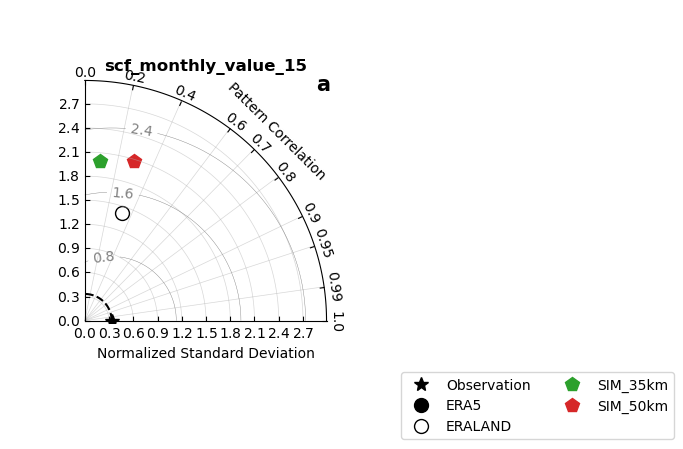

In [9]:
list_var = ['scf']#, 'ext']
list_label = ['scf_monthly_value_15']#, 'ext_days_with_snow_15']
rects = [221]#, 222]
abc = ['a']#, 'b']
srange = [(0, 9)]#, (0, 9)]

fig = plt.figure(figsize=(7,7))

# Calcul des indices sous forme de dictionnaire {var:{prod1:[std,corr], prod2:[std,corr]},...}
dict_month = {}  
for mon in [11]:
    
    corr_std_par_dic = {par:'data' for par in parameters}   
    #print(corr_std_par_dic)
    for par in parameters:   
        dict_month[par] = {} 
        for ctr,prod in enumerate(products_labels):    
            #print('std : ',np.std(dic_data['1000m_1500m'][prod][par].dropna(dim='time').values))
            
            std = (np.std(dic_data['1000m_1500m'][prod][par].dropna(dim='time').values))
            #print('Corr : ',scipy.stats.pearsonr(dic_data['1000m_1500m'][ref][par].dropna(dim='time').groupby('time.month')[mon].values, dic_data['1000m_1500m'][prod][par].dropna(dim='time').groupby('time.month')[mon].values)[0])
            corr = (scipy.stats.pearsonr(dic_data['1000m_1500m'][ref][par].dropna(dim='time').groupby('time.month')[mon].values, dic_data['1000m_1500m'][prod][par].dropna(dim='time').groupby('time.month')[mon].values)[0]) 
            #print('label : ',  prod)
            lab = (prod) 
            dict_month[par][prod] = [std, np.abs(corr)]
        
print(dict_month)  
        #print(corr_std_par_dic[par])


for i, var in enumerate(list_var):
    
    std_obs = dict_month[list_label[i]]['ESA_ORIG'][0]
    dia = TaylorDiagram(std_obs, fig=fig, rect=rects[i], label='Observation', srange=srange[i], extend=False)
#     dia = TaylorDiagram(std_obs[i], fig=fig, rect=rects[i], label='Observation', srange=(0, 5), extend=True)
    
    # ERALAND and ERA5
    std_era5 = dict_month[list_label[i]]['ERA5'][0]
    corr_era5 = dict_month[list_label[i]]['ERA5'][1]
    dia.add_sample(std_era5, corr_era5, marker='o', ms=10, ls='', mfc='k', mec='k', label='ERA5', zorder=0)
    std_eral = dict_month[list_label[i]]['ERA_LAND'][0]
    corr_eral = dict_month[list_label[i]]['ERA_LAND'][1]
    dia.add_sample(std_eral, corr_eral, marker='o', ms=10, ls='', mfc=(0, 0, 0, 0), mec='k', label='ERALAND', zorder=1)
    
    # GPCP
    #if var == 'pr':
        #dia.add_sample(std_GPCP.item(0)/std_obs[i], corr_GPCP, marker='*', ms=10, ls='', mfc=(0, 0, 0, 0), mec='k', label='GPCP', zorder=1)
        #dia._ax.text(0.28, 0.15, 'GPCP', size=9, transform=dia._ax.transAxes)
    
    #for j, model in enumerate(list_models):
        #dia.add_sample(std_models[i][j]/std_obs[i], corr_models[i][j], marker=marker[j], ms=10, ls='', mfc=mfc[j], mec=mec[j],label=model, zorder=j)
        
    # MMM
    std_sim35 = dict_month[list_label[i]]['SIM_35km'][0]
    corr_sim35 = dict_month[list_label[i]]['SIM_35km'][1]
    dia.add_sample(std_sim35, corr_sim35, marker='p', ms=10, ls='',  label='SIM_35km', zorder=0)
    std_sim50 = dict_month[list_label[i]]['SIM_50km'][0]
    corr_sim50 = dict_month[list_label[i]]['SIM_50km'][1]
    dia.add_sample(std_sim50, corr_sim50, marker='p', ms=10, ls='',label='SIM_50km', zorder=1)
        

        
           
    dia._ax.set_title(list_label[i], fontweight="bold")
    dia._ax.text(0.95, 0.95, abc[i], size=15, weight='bold', transform=dia._ax.transAxes)
    
    # Add RMS contours, and label them
    contours = dia.add_contours(levels=3, colors='0.5', linewidths=0.3)  # 5 levels in grey
    PLT.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
    
    # Grid
    dia._ax.grid(lw=0.5, alpha=0.5)


fig.legend(dia.samplePoints,
           [ p.get_label() for p in dia.samplePoints ],
           numpoints=1, bbox_to_anchor=(0.98, 0.47), ncol=2)

# fig.suptitle("Taylor diagram of spatial climatologies "+str(period.start)+"-"+period.stop, size='x-large')  # Figure title

fig.tight_layout()

# for ext in ['jpg', 'png', 'pdf']:
#     fig.savefig('img/fig_taylor_diagram_Annual_PCC_'+str(period.start)+'-'+period.stop+'.'+ext, dpi=300, bbox_inches='tight')